# Maximum a posteriori and Sparse Coding

This illustrates the basic idea for Sparse Collective Perception (SCP)

## Load the trajectory data, as usual

In [1]:
import numpy as np
import pickle 
from matplotlib import pyplot as plt 
trajectory_file = open("trajectories.pyo", "rb")
trajs = pickle.load(trajectory_file)
y_vec = np.array(trajs['y_vec'])
t_vec = np.array(trajs['t_vec'])
del trajs
trajectory_file.close()
del trajectory_file

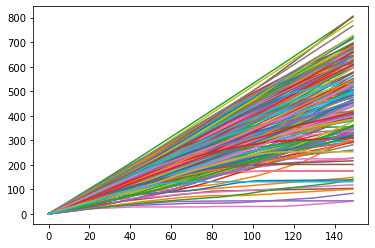

In [2]:
for traj in range(y_vec.shape[0]):
    plt.plot(y_vec[traj])

This is the sample trajectory dataset

Let's generate exemplary observations stream

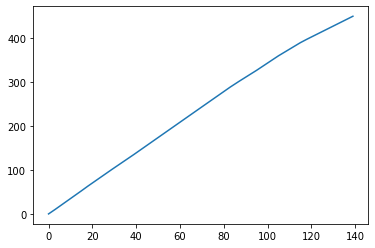

In [132]:
y_test = y_vec[8,:140]
plt.plot(y_test)

## Let's try Spline basis first

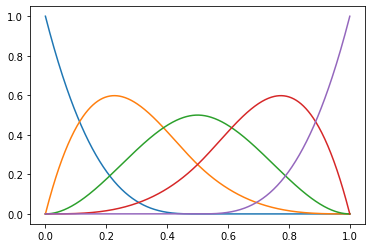

In [89]:
import skfda

# Spline basis
n_basis = 5
basis = skfda.representation.basis.BSpline(n_basis=n_basis)
basis.plot()

Convert data to the spline basis

In [90]:
fdgry = skfda.FDataGrid(y_vec, t_vec)
fdgry_in_splines = fdgry.to_basis(basis)
y_coeffs = fdgry_in_splines.coefficients
friendly_basis = np.zeros((n_basis, t_vec.shape[0]))
for i in range(n_basis):
    friendly_basis[i,:] = fdgry_in_splines.basis.evaluate(t_vec)[i].reshape(-1)

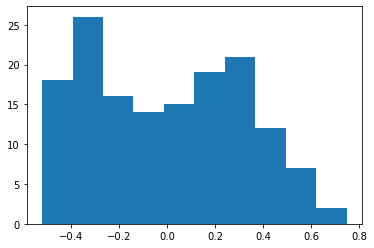

In [91]:
for i in range(1):
    y_r = y_coeffs[i] @ friendly_basis
    plt.hist(y_vec[i] - y_r)

Seems like the reconstruction error is pretty adequate with 5 basis

## Learning the prior distribution

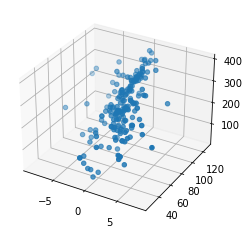

In [92]:
# Visualizing the first three components
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(y_coeffs[:,0], y_coeffs[:,1], y_coeffs[:,2])

In [93]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
bandwidth_candidates = 10 ** np.linspace(1,10,100) # 10^x from -1 to 1
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidth_candidates}, cv=LeaveOneOut())
grid.fit(y_coeffs)
#kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(y_coeffs)
#plt.hist(kde.score_samples(y_coeffs))

GridSearchCV(cv=LeaveOneOut(), estimator=KernelDensity(),
             param_grid={'bandwidth': array([1.00000000e+01, 1.23284674e+01, 1.51991108e+01, 1.87381742e+01,
       2.31012970e+01, 2.84803587e+01, 3.51119173e+01, 4.32876128e+01,
       5.33669923e+01, 6.57933225e+01, 8.11130831e+01, 1.00000000e+02,
       1.23284674e+02, 1.51991108e+02, 1.87381742e+02, 2.31012970e+02,
       2.84803587e+02, 3.511191...
       8.11130831e+07, 1.00000000e+08, 1.23284674e+08, 1.51991108e+08,
       1.87381742e+08, 2.31012970e+08, 2.84803587e+08, 3.51119173e+08,
       4.32876128e+08, 5.33669923e+08, 6.57933225e+08, 8.11130831e+08,
       1.00000000e+09, 1.23284674e+09, 1.51991108e+09, 1.87381742e+09,
       2.31012970e+09, 2.84803587e+09, 3.51119173e+09, 4.32876128e+09,
       5.33669923e+09, 6.57933225e+09, 8.11130831e+09, 1.00000000e+10])})

In [94]:
grid.best_params_

{'bandwidth': 15.199110829529339}

In [95]:
kde = KernelDensity(kernel='gaussian', bandwidth=15.12).fit(y_coeffs)

In [96]:
# Save the KDE so that we don't have to learn from the data the next time the algorithm is run
with open('kde.pyo', 'wb') as f:
    pickle.dump(kde, f, pickle.HIGHEST_PROTOCOL)
print('The file has been saved successfully!')

The file has been saved successfully!


In [97]:
y_test.shape

(140,)

## Sequential Importance Resampling (SIR) of the Posterior Distribution

In [98]:
friendly_basis.shape

(5, 150)

In [162]:
from scipy.stats import norm 
def likelihood(z, theta, t):
    reconstructed_trajectory = theta.T @ friendly_basis 
    #print('Mean: ', reconstructed_trajectory[t])
    #print('Test: ', z)
    #raise Exception("LALALA")
    return norm.pdf(z, loc=reconstructed_trajectory[t], scale=3.0) # scale is the std

In [163]:
# Low variance resampling
def lvr(particles, weights): # requires normalized weights first
    # return: new particles with equal weights
    M = particles.shape[0] # number of particles
    new_particles = np.zeros_like(particles)
    # new_particles_weight = np.ones((M,)) / M 
    # W = np.sum(weights)
    r = np.random.rand() / M # get a random number between 0 and 1/M
    c = weights[0]
    i = 0
    for m in range(M):
        U = r + m/M
        while U>c:
            i+=1
            c+=weights[i]
        new_particles[m] = particles[i]
    return new_particles


In [164]:
pars = np.array([1,3,5,7,9])
wghs = np.array([0.1, 0.4, 0.1, 0.1, 0.3])
lvr(pars, wghs)

array([3, 3, 5, 9, 9])

## Selective Broadcasting Filter

In [245]:
n_particles = 5000 
map_particle_available = False

# Step 1: generate a bunch of particles from the prior distribution
particles = kde.sample(n_particles, random_state=6969)
weights = np.ones((n_particles,)) / n_particles
map_components_log = np.zeros((y_test.shape[0], particles.shape[1]))
weights_variance_log = np.zeros((y_test.shape[0],))
measurement_likelihood_log = np.zeros((y_test.shape[0],))
error_log = np.zeros((y_test.shape[0],))
broadcast_log = np.zeros((y_test.shape[0],))

for t in range(y_test.shape[0]):
    # When measurement arrives, calculate the importance weights first
    weights_normalization_coeff = 0
    for j in range(weights.shape[0]):
        measurement_likelihood = likelihood(y_test[t], particles[j,:], t)
        weights[j] = measurement_likelihood
        weights_normalization_coeff += weights[j]
        measurement_likelihood_log[t] += measurement_likelihood

    # print(t, measurement_likelihood)

    # Normalization all the weights
    for j in range(weights.shape[0]):
        weights[j] = weights[j] / weights_normalization_coeff
    
    if not map_particle_available: # first assignment of map_particle_value
        # Get the index of the particle with largest weight, that will be our maximum-a-posteriori estimate 
        map_particle_index = np.argmax(weights)
        map_particle_value = particles[map_particle_index]
        map_components_log[t,:] = map_particle_value
        map_particle_available = True
        
    error_log[t] = np.abs(((map_particle_value) @ friendly_basis)[t] - y_test[t])
    
    if error_log[t] > 3.0:
        map_particle_index = np.argmax(weights)
        map_particle_value = particles[map_particle_index]
        map_components_log[t,:] = map_particle_value
        broadcast_log[t] = 1
    
    # Resample the particles according to the particle weights
    if measurement_likelihood_log[t] < 100:
        particles = lvr(particles, weights)
        weights = np.ones((n_particles,)) / n_particles

    weights_variance_log[t] = np.var(weights)

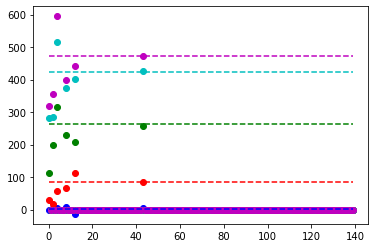

In [246]:
plt.plot(map_components_log[:,0],'bo')
plt.plot(map_components_log[:,1],'ro')
plt.plot(map_components_log[:,2],'go')
plt.plot(map_components_log[:,3],'co')
plt.plot(map_components_log[:,4],'mo')
plt.plot(np.tile(y_coeffs[8,0],140),'b--')
plt.plot(np.tile(y_coeffs[8,1],140),'r--')
plt.plot(np.tile(y_coeffs[8,2],140),'g--')
plt.plot(np.tile(y_coeffs[8,3],140),'c--')
plt.plot(np.tile(y_coeffs[8,4],140),'m--')

## Particle Filter

In [247]:
n_particles = 5000 
map_particle_available = False

# Step 1: generate a bunch of particles from the prior distribution
particles = kde.sample(n_particles, random_state=6969)
weights = np.ones((n_particles,)) / n_particles
map_components_log = np.zeros((y_test.shape[0], particles.shape[1]))
weights_variance_log = np.zeros((y_test.shape[0],))
measurement_likelihood_log = np.zeros((y_test.shape[0],))
error_log = np.zeros((y_test.shape[0],))
broadcast_log = np.zeros((y_test.shape[0],))

for t in range(y_test.shape[0]):
    # When measurement arrives, calculate the importance weights first
    weights_normalization_coeff = 0
    for j in range(weights.shape[0]):
        measurement_likelihood = likelihood(y_test[t], particles[j,:], t)
        weights[j] = measurement_likelihood
        weights_normalization_coeff += weights[j]
        measurement_likelihood_log[t] += measurement_likelihood

    # print(t, measurement_likelihood)

    # Normalization all the weights
    for j in range(weights.shape[0]):
        weights[j] = weights[j] / weights_normalization_coeff
    

    map_particle_index = np.argmax(weights)
    map_particle_value = particles[map_particle_index]
    map_components_log[t,:] = map_particle_value
    map_particle_available = True
    error_log[t] = np.abs(((map_particle_value) @ friendly_basis)[t] - y_test[t])
    
    # Resample the particles according to the particle weights
    if measurement_likelihood_log[t] < 100:
        particles = lvr(particles, weights)
        weights = np.ones((n_particles,)) / n_particles

    weights_variance_log[t] = np.var(weights)

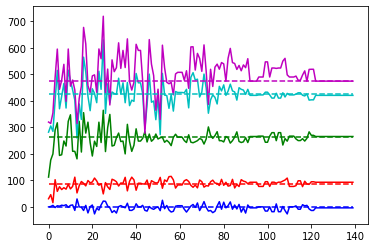

In [248]:
plt.plot(map_components_log[:,0],'b')
plt.plot(map_components_log[:,1],'r')
plt.plot(map_components_log[:,2],'g')
plt.plot(map_components_log[:,3],'c')
plt.plot(map_components_log[:,4],'m')
plt.plot(np.tile(y_coeffs[8,0],140),'b--')
plt.plot(np.tile(y_coeffs[8,1],140),'r--')
plt.plot(np.tile(y_coeffs[8,2],140),'g--')
plt.plot(np.tile(y_coeffs[8,3],140),'c--')
plt.plot(np.tile(y_coeffs[8,4],140),'m--')

## Analysis Charts

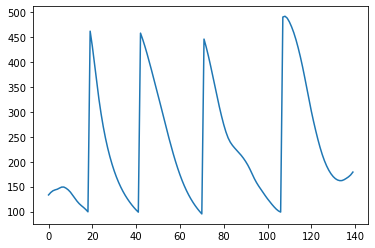

In [249]:
plt.plot(measurement_likelihood_log) # the higher, the better

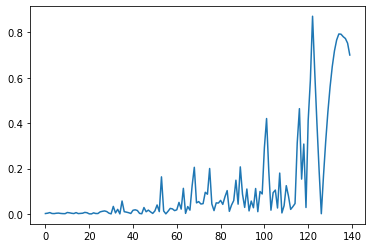

In [250]:
plt.plot(error_log)

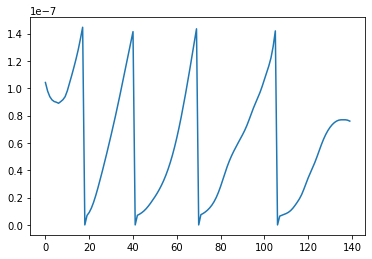

In [251]:
plt.plot(weights_variance_log)

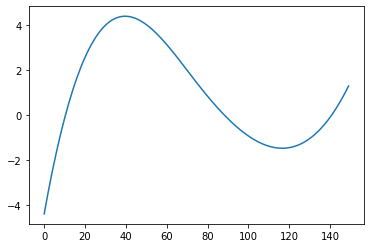

In [252]:
predicted_traj = plt.plot(map_particle_value @ friendly_basis - y_coeffs[8] @ friendly_basis)

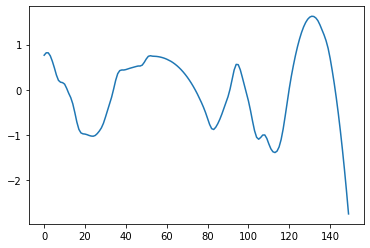

In [253]:
predicted_traj = plt.plot(y_coeffs[8] @ friendly_basis - y_vec[8])

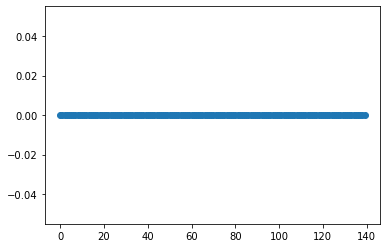

In [254]:
plt.plot(broadcast_log, 'o')

In [255]:
broadcast_log.sum()

0.0

## Dictionary learning

In [21]:
from sklearn.decomposition import DictionaryLearning
dicc = DictionaryLearning(n_components=100, alpha=1, max_iter=1000)
dicc_components = dicc.fit(y_vec).components_

KeyboardInterrupt: 

Dictionary elements

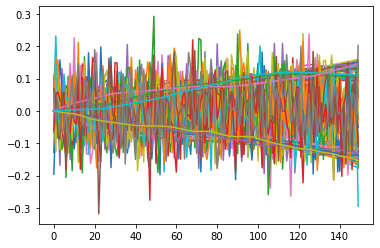

In [ ]:
for i in range(dicc_components.shape[0]):
    plt.plot(dicc_components[i])

Time to test the coded sample trajectories

In [ ]:
dicc.set_params(transform_algorithm='omp', transform_n_nonzero_coefs=1)
code = dicc.transform(y_vec[3].copy().reshape(-1,1).transpose())

Let's reconstruct

In [ ]:
reconstruct = np.dot(code, dicc.components_)

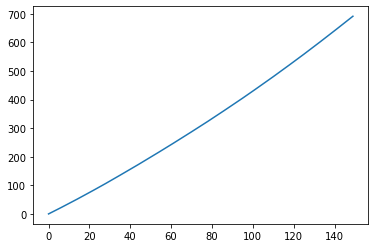

In [ ]:
plt.plot(reconstruct.transpose())

In [ ]:
synth1 = np.load('synth1.npz')['data']
synth2 = np.load('synth2.npz')['data']

In [ ]:
dicc.set_params(transform_algorithm='omp', transform_n_nonzero_coefs=5)
code_s1 = dicc.transform(synth1.reshape(-1,1).transpose())
code_s1

array([[    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
        -2082.54634232,     0.        ,     0.        ,     0.        ,
         7081.09386217,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,   -32.31418797,     0.  

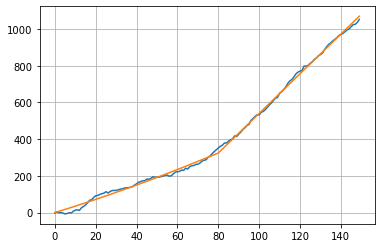

In [ ]:
reconstruct_s1 = np.dot(code_s1, dicc.components_).transpose()
plt.plot(reconstruct_s1)
plt.plot(synth1.reshape((-1,1)))
plt.grid(True)

(array([ 4., 10., 11., 22., 20., 25., 24., 17., 12.,  5.]),
 array([-30.79631731, -24.99345943, -19.19060154, -13.38774365,
         -7.58488577,  -1.78202788,   4.02083   ,   9.82368789,
         15.62654577,  21.42940366,  27.23226154]),
 <BarContainer object of 10 artists>)

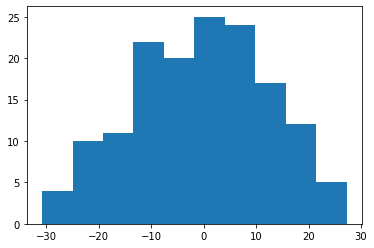

In [ ]:
plt.hist(reconstruct_s1 - synth1.reshape((-1,1)))